In [1]:
# Set up the environment

import sys

# Add path for python to look into for modules installed using pip

sys.path.append('/usr/local/lib/python3.7/site-packages/')

from alpha_vantage.timeseries import TimeSeries # https://www.alphavantage.co/documentation/

from alpha_vantage.techindicators import TechIndicators # https://github.com/RomelTorres/alpha_vantage

# Set AlphaVantage API key

api_key = '2HTD0A5HTZ0MZW19'

ts = TimeSeries(key=api_key, output_format='pandas')

ti = TechIndicators(key=api_key, output_format='pandas')

# Import other libraries

from datapackage import Package

import quandl

import pandas_datareader.data as web

import pandas as pd
import numpy as np
from math import ceil, floor
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import os

# Ignore FutureWarnings

# import warnings
# warnings.simplefilter(action = 'ignore', category = FutureWarning)

# Set seaborn options

# sns.set(style = 'darkgrid', context = 'talk', palette = 'Dark2')

# Set global matplotlib options (https://matplotlib.org/tutorials/introductory/customizing.html)

matplotlib.rcParams['figure.figsize'] = (12, 6)
matplotlib.rcParams['figure.dpi'] = 240
matplotlib.rcParams['axes.titlesize'] = 16
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['axes.grid.which'] = 'both'
matplotlib.rcParams['legend.fontsize'] = 'large'

# matplotlib.rcParams.keys()

# Define essential functions

In [2]:
# Define start/end dates

start_date = '2015-01-01'

end_date = datetime.datetime.today().date()

##########################################################################################
##########################################################################################

# RMSE function

def RMSE(observations, predictions):
    return np.sqrt(((predictions - observations) ** 2).mean())

##########################################################################################
##########################################################################################

# Define a function to organise and wrangle Alpha Vantage data

def alpha_wrangle(stock, start=start_date, end=end_date):
    
    # Check start/end dates format
    
    if isinstance(start, datetime.date):
        pass
    else:
        start = datetime.datetime.strptime(start, '%Y-%m-%d').date()


    if isinstance(end, datetime.date):
        pass
    else:
        end = datetime.datetime.strptime(end, '%Y-%m-%d').date()
        
    # Data pulling and wrangling
    
    # Get an object with the daily data and another with the call's metadata

    data, _ = ts.get_daily_adjusted(symbol = stock, outputsize = 'full')

    data.index = pd.to_datetime(data.index, format = '%Y-%m-%d').date

    # Rename columns for consistency and easier manipulation

    data.columns = [c.replace(' ', '_')[3:] for c in data.columns]

    # data.drop(labels = ['dividend_amount', 'split_coeff'], axis = 1, inplace = True)

    data['date'] = data.index

    # Subset table based on dates

    mask = (data['date'] >= start) & (data['date'] <= end)

    data = data.loc[mask]

    # Add extra columns with more data

    data['daily_range'] = abs(data.high - data.low)

    data['relative_returns'] = data['adjusted_close'].pct_change(1)

    # Log returns - First the logarithm of the prices is taken and then
    # the difference of consecutive (log) observations

    data['log_returns'] = np.log(data['adjusted_close']).diff()

#     data['cumsum_log_returns'] = data['log_returns'].cumsum()
    
#     # Moving averages

#     data['sma_20'] = data['adjusted_close'].rolling(window = 20).mean()

#     data['sma_50'] = data['adjusted_close'].rolling(window = 50).mean()

#     data['sma_100'] = data['adjusted_close'].rolling(window = 100).mean()

    # Exponential moving average

    data['ema_20'] = data['adjusted_close'].ewm(span = 20, adjust = False).mean()

    data['ema_50'] = data['adjusted_close'].ewm(span = 50, adjust = False).mean()

    data['ema_100'] = data['adjusted_close'].ewm(span = 100, adjust = False).mean()
    
#     time.sleep(15)
    
    return data

##########################################################################################
##########################################################################################

# Get Bollinger Bands from Alpha Vantage

# https://www.investopedia.com/articles/technical/04/030304.asp

def get_bb(stock, start=start_date, end=end_date):
    
    # Check start/end dates format
    
    if isinstance(start, datetime.date):
        pass
    else:
        start = datetime.datetime.strptime(start, '%Y-%m-%d').date()


    if isinstance(end, datetime.date):
        pass
    else:
        end = datetime.datetime.strptime(end, '%Y-%m-%d').date()
        
    # Data pulling and wrangling
    
    bb, _ = ti.get_bbands(symbol=stock, interval='daily', matype=1)
    
    bb.index = pd.to_datetime(bb.index, format = '%Y-%m-%d').date
    
    # Rename columns for consistency and easier manipulation

    bb.columns = [c.replace(' ', '_').lower() for c in bb.columns]

    # Subset table based on dates
    
    bb['date'] = bb.index

    mask = (bb['date'] >= start) & (bb['date'] <= end)

    bb = bb.loc[mask]
    
    bb.drop(labels = ['date'], axis=1, inplace=True)
    
    return bb

##########################################################################################
##########################################################################################

# Get RSI from Alpha Vantage

# https://www.investopedia.com/articles/active-trading/042114/
# overbought-or-oversold-use-relative-strength-index-find-out.asp

def get_rsi(stock, start=start_date, end=end_date):
    
    # Check start/end dates format
    
    if isinstance(start, datetime.date):
        pass
    else:
        start = datetime.datetime.strptime(start, '%Y-%m-%d').date()


    if isinstance(end, datetime.date):
        pass
    else:
        end = datetime.datetime.strptime(end, '%Y-%m-%d').date()
        
    # Data pulling and wrangling
    
    rsi, _ = ti.get_rsi(symbol=stock, interval='daily')
    
    rsi.index = pd.to_datetime(rsi.index, format = '%Y-%m-%d').date
    
    # Rename columns for consistency and easier manipulation

    rsi.columns = [c.replace(' ', '_') for c in rsi.columns]
    
    # Subset table based on dates
    
    rsi['date'] = rsi.index

    mask = (rsi['date'] >= start) & (rsi['date'] <= end)

    rsi = rsi.loc[mask]
    
    rsi.drop(labels = ['date'], axis=1, inplace=True)
    
    rsi.sort_index(ascending=False, inplace=True)
    
    return rsi

##########################################################################################
##########################################################################################

# Get ADX

# https://www.investopedia.com/articles/trading/07/adx-trend-indicator.asp

def get_adx(stock, start=start_date, end=end_date):
    
    # Check start/end dates format
    
    if isinstance(start, datetime.date):
        pass
    else:
        start = datetime.datetime.strptime(start, '%Y-%m-%d').date()


    if isinstance(end, datetime.date):
        pass
    else:
        end = datetime.datetime.strptime(end, '%Y-%m-%d').date()
        
    # Data pulling and wrangling
    
    adx, _ = ti.get_adx(symbol=stock, interval='daily')
    
    adx.index = pd.to_datetime(adx.index, format = '%Y-%m-%d').date
    
    # Rename columns for consistency and easier manipulation

    adx.columns = [c.replace(' ', '_') for c in adx.columns]
    
    # Subset table based on dates
    
    adx['date'] = adx.index

    mask = (adx['date'] >= start) & (adx['date'] <= end)

    adx = adx.loc[mask]
    
    adx.drop(labels = ['date'], axis=1, inplace=True)
    
    adx.sort_index(ascending=False, inplace=True)
    
    return adx

##########################################################################################
##########################################################################################

# Get MACD

# https://www.investopedia.com/articles/forex/05/macddiverge.asp

def get_macd(stock, start=start_date, end=end_date):
    
    # Check start/end dates format
    
    if isinstance(start, datetime.date):
        pass
    else:
        start = datetime.datetime.strptime(start, '%Y-%m-%d').date()


    if isinstance(end, datetime.date):
        pass
    else:
        end = datetime.datetime.strptime(end, '%Y-%m-%d').date()
        
    # Data pulling and wrangling
    
    macd, _ = ti.get_macd(symbol=stock, interval='daily')
    
    macd.index = pd.to_datetime(macd.index, format = '%Y-%m-%d').date
    
    # Rename columns for consistency and easier manipulation

    macd.columns = [c.replace(' ', '_') for c in macd.columns]
    
    # Subset table based on dates
    
    macd['date'] = macd.index

    mask = (macd['date'] >= start) & (macd['date'] <= end)

    macd = macd.loc[mask]
    
    macd.drop(labels = ['MACD_Hist', 'MACD_Signal', 'date'], axis = 1, inplace = True)
    
    return macd

##########################################################################################
##########################################################################################

# Get bond data from datahub.io

def get_bonds(package, freq, start=start_date, end=end_date):

    bond_data = Package(package)

    # Convert to pandas dataframe

    bond_data = pd.DataFrame(bond_data.get_resource(freq).read())

    # Data wrangling
    
    bond_data.columns = ['date', 'yield']

    bond_data['date'] = pd.to_datetime(bond_data['date'], format = '%Y-%m-%d')

    bond_data.index = bond_data['date']

    bond_data['day'] = bond_data.index.day

    bond_data['month'] = bond_data.index.month

    bond_data['year'] = bond_data.index.year

    bond_data.drop(labels = ['date', 'day'], axis = 1, inplace = True)

    bond_data = bond_data.loc[bond_data.year >= datetime.datetime.strptime(start_date, '%Y-%m-%d').date().year]
    
    return bond_data

##########################################################################################
##########################################################################################

# Get VIX data from datahub.io

def get_vix(package='https://datahub.io/core/finance-vix/datapackage.json',
            freq='vix-daily_csv',
            start=start_date,
            end=end_date):
    
    vix_data = Package(package)

    # Convert to pandas dataframe

    vix_data = pd.DataFrame(vix_data.get_resource(freq).read())

    # Data wrangling
    
    vix_data.columns = ['date', 'vix_open', 'vix_high', 'vix_low', 'vix_close']
    
    vix_data['date'] = pd.to_datetime(vix_data['date'], format = '%Y-%m-%d')

    vix_data.index = vix_data['date']

    vix_data['day'] = vix_data.index.day

    vix_data['month'] = vix_data.index.month

    vix_data['year'] = vix_data.index.year

    vix_data = vix_data.loc[vix_data.year >= datetime.datetime.strptime(start_date, '%Y-%m-%d').date().year]
    
    vix_data.drop(labels = ['date', 'day', 'month', 'year'], axis = 1, inplace = True)
    
    return vix_data

##########################################################################################
##########################################################################################

# Get Natural Gas data from datahub.io

def get_nat_gas(package='https://datahub.io/core/natural-gas/datapackage.json',
                freq='daily_csv',
                start=start_date,
                end=end_date):
    
    nat_gas = Package(package)

    # Convert to pandas dataframe

    nat_gas = pd.DataFrame(nat_gas.get_resource(freq).read())

    # Data wrangling
    
    nat_gas.columns = ['date', 'nat_gas_price']
    
    nat_gas['date'] = pd.to_datetime(nat_gas['date'], format = '%Y-%m-%d')

    nat_gas.index = nat_gas['date']

#     nat_gas['day'] = nat_gas.index.day

#     nat_gas['month'] = nat_gas.index.month

#     nat_gas['year'] = nat_gas.index.year

    mask = (nat_gas['date'] >= start) & (nat_gas['date'] <= end)
    
    nat_gas.drop(labels = ['date'], axis = 1, inplace = True)

    nat_gas = nat_gas.loc[mask]
    
    return nat_gas

##########################################################################################
##########################################################################################

# Get oil data from Quandl
# https://www.quandl.com/data/WGEC-World-Bank-Global-Economic-Monitor-GEM-Commodities

def get_oil(start=start_date, end=end_date):
    
    oil = quandl.get('NASDAQOMX/NQCICLER', start_date=start, end_date=end)
    
    oil.columns = [c.replace(' ', '_') for c in oil.columns]
    
    return oil

# Pull data for bonds

In [3]:
###########
##### BONDS
###########


# 10 year US Government Bond Yields (long-term interest rate)
# https://datahub.io/core/bond-yields-us-10y#python

# ten_yr_us_bond = get_bonds(package='https://datahub.io/core/bond-yields-us-10y/datapackage.json',
#                            freq='monthly_csv')


# 10y UK Government Bond Yields (long-term interest rate)
# https://datahub.io/core/bond-yields-uk-10y#python

# ten_yr_uk_bond = get_bonds(package='https://datahub.io/core/bond-yields-uk-10y/datapackage.json',
#                            freq='quarterly_csv')


# 2-Year Treasury Constant Maturity Rate (DGS2)
# https://fred.stlouisfed.org/series/DGS2

two_yr_us_bond = web.DataReader('DGS2', 'fred', start_date, end_date)


# 10-Year Treasury Constant Maturity Rate (DGS10)
# https://fred.stlouisfed.org/series/DGS10

ten_yr_us_bond = web.DataReader('DGS10', 'fred', start_date, end_date)


# 30-Year Treasury Constant Maturity Rate (DGS30)
# https://fred.stlouisfed.org/series/DGS30

thirty_yr_us_bond = web.DataReader('DGS30', 'fred', start_date, end_date)


#################
##### NATURAL GAS
#################

# Natural gas prices
# https://datahub.io/core/natural-gas#python

# nat_gas = get_nat_gas()

#########
##### OIL
#########

# Get NASDAQ Commodity Crude Oil Index ER (NQCICLER)

# oil = get_oil()

# Pull data for VIX and volatility indexes

In [4]:
# VIX - CBOE Volatility Index
# https://datahub.io/core/finance-vix#python

vix = get_vix()

# CBOE Volatility Index: VIX
# https://fred.stlouisfed.org/series/VIXCLS

# vix = web.DataReader('VIXCLS', 'fred', start_date, end_date)

# CBOE Crude Oil ETF Volatility Index
# https://fred.stlouisfed.org/series/OVXCLS

oil_etf_vol = web.DataReader('OVXCLS', 'fred', start_date, end_date)

# CBOE Gold ETF Volatility Index
# https://fred.stlouisfed.org/series/GVZCLS

gold_etf_vol = web.DataReader('GVZCLS', 'fred', start_date, end_date)

# CBOE China ETF Volatility Index
# https://fred.stlouisfed.org/series/VXFXICLS

china_etf_vol = web.DataReader('VXFXICLS', 'fred', start_date, end_date)

# CBOE Emerging Markets ETF Volatility Index
# https://fred.stlouisfed.org/series/VXEEMCLS

emer_markets_etf_vol = web.DataReader('VXEEMCLS', 'fred', start_date, end_date)

# CBOE Russell 2000 Volatility Index
# https://fred.stlouisfed.org/series/RVXCLS

russel_2k_etf_vol = web.DataReader('RVXCLS', 'fred', start_date, end_date)

# CBOE Energy Sector ETF Volatility Index
# https://fred.stlouisfed.org/series/VXXLECLS

energy_etf_vol = web.DataReader('VXXLECLS', 'fred', start_date, end_date)

# Pull data for indexes

In [5]:
# # Get Dow Jones index data from AlphaVantage

# d_jones = alpha_wrangle(stock='DJI')

# # Get S&P500 index data from AlphaVantage

# sp500 = alpha_wrangle(stock='INX')

# S&P500
# https://fred.stlouisfed.org/series/SP500

sp500 = web.DataReader('SP500', 'fred', start_date, end_date)

# Dow Jones Industrial Average
# https://fred.stlouisfed.org/series/DJIA

d_jones = web.DataReader('DJIA', 'fred', start_date, end_date)

# NASDAQ
# https://fred.stlouisfed.org/series/NASDAQCOM

nasdaq = web.DataReader('NASDAQCOM', 'fred', start_date, end_date)

# Pull other data/indicators

In [6]:
crude_oil_texas = web.DataReader('DCOILWTICO', 'fred', start_date, end_date)

gold_morning = web.DataReader('GOLDAMGBD228NLBM', 'fred', start_date, end_date)

gold_afternoon = web.DataReader('GOLDPMGBD228NLBM', 'fred', start_date, end_date)

crude_oil_brent = web.DataReader('DCOILBRENTEU', 'fred', start_date, end_date)

hh_natural_gas = web.DataReader('DHHNGSP', 'fred', start_date, end_date)

high_yield_master_II_tri = web.DataReader('BAMLHYH0A0HYM2TRIV', 'fred', start_date, end_date)

corporate_master_tri = web.DataReader('BAMLCC0A0CMTRIV', 'fred', start_date, end_date)

economic_uncertainty_index = web.DataReader('WLEMUINDXD', 'fred', start_date, end_date)

In [7]:
other = crude_oil_texas.join(gold_morning).join(gold_afternoon).join(crude_oil_brent).join(hh_natural_gas)

other = other.join(high_yield_master_II_tri).join(corporate_master_tri).join(economic_uncertainty_index)

other.sort_index(ascending=False, inplace=True)

# Pull AlphaVantage data

In [8]:
# Get stock data

stock = 'AMZN'

stock_data = alpha_wrangle(stock=stock)

# Get data for vairous indicators

rsi = get_rsi(stock=stock)

bb = get_bb(stock=stock)

adx = get_adx(stock=stock)

macd = get_macd(stock=stock)

In [9]:
# Get forex data

usd_eur = web.DataReader('DEXUSEU', 'fred', start_date, end_date) # euro

cny_usd = web.DataReader('DEXCHUS', 'fred', start_date, end_date) # chinese yuan

jpy_usd = web.DataReader('DEXJPUS', 'fred', start_date, end_date) # japanese yen

cad_usd = web.DataReader('DEXCAUS', 'fred', start_date, end_date) # canadian dollar

usd_gbp = web.DataReader('DEXUSUK', 'fred', start_date, end_date) # british pounds

krw_usd = web.DataReader('DEXKOUS', 'fred', start_date, end_date) # south korean won

mxn_usd = web.DataReader('DEXMXUS', 'fred', start_date, end_date) # mexican peso

brl_usd = web.DataReader('DEXBZUS', 'fred', start_date, end_date) # brazilian real

inr_usd = web.DataReader('DEXINUS', 'fred', start_date, end_date) # indian rupee

aud_usd = web.DataReader('DEXUSAL', 'fred', start_date, end_date) # australian dollar

chf_usd = web.DataReader('DEXSZUS', 'fred', start_date, end_date) # swiss franc

thb_usd = web.DataReader('DEXTHUS', 'fred', start_date, end_date) # thai baht

twd_usd = web.DataReader('DEXTAUS', 'fred', start_date, end_date) # new taiwan dollar

zar_usd = web.DataReader('DEXSFUS', 'fred', start_date, end_date) # south african rand

hkd_usd = web.DataReader('DEXHKUS', 'fred', start_date, end_date) # hong kong dollar

myr_usd = web.DataReader('DEXMAUS', 'fred', start_date, end_date) # malaysian ringgit

sek_usd = web.DataReader('DEXSDUS', 'fred', start_date, end_date) # swidish krona

sgd_usd = web.DataReader('DEXSIUS', 'fred', start_date, end_date) # singapore dollar

nok_usd = web.DataReader('DEXNOUS', 'fred', start_date, end_date) # norwegian krone

dkk_usd = web.DataReader('DEXDNUS', 'fred', start_date, end_date) # danish krone

lkr_usd = web.DataReader('DEXSLUS', 'fred', start_date, end_date) # sri lankan rupee

nzd_usd = web.DataReader('DEXUSNZ', 'fred', start_date, end_date) # new zeland dollar

In [10]:
# Join forex data

forex = usd_eur.join(cny_usd).join(jpy_usd).join(cad_usd).join(usd_gbp).join(krw_usd).join(mxn_usd)

forex = forex.join(brl_usd).join(inr_usd).join(aud_usd).join(chf_usd).join(thb_usd).join(twd_usd)

forex = forex.join(zar_usd).join(hkd_usd).join(myr_usd).join(sek_usd).join(sgd_usd).join(nok_usd)

forex.join(dkk_usd).join(lkr_usd).join(nzd_usd)

forex.sort_index(ascending=False, inplace=True)

# Join datasets

In [11]:
# Set prediction period (in days)

pred_period = 30

# Join volatility datasets

vol_data = vix.join(oil_etf_vol).join(gold_etf_vol).join(china_etf_vol)

vol_data = vol_data.join(emer_markets_etf_vol).join(russel_2k_etf_vol).join(energy_etf_vol)#.dropna(axis=0)

# Join major index data

index_data = sp500.join(d_jones).join(nasdaq)

# Join all extra datasets

technical_ind = bb.join(rsi).join(adx).join(macd)

# Join all of the above together

alt_data = index_data.join(vol_data).join(technical_ind).join(other).join(forex)

# Add this to the stock data

cols_to_drop = ['open', 'high', 'low', 'close', 'date', 'vix_open', 'vix_high', 'vix_low']

data = stock_data.join(alt_data).drop(labels = cols_to_drop, axis = 1).dropna(axis=0)

In [12]:
# Create shifted dataset

cols_to_drop = ['adjusted_close', 'open', 'high', 'low', 'close', 'date', 'vix_open', 'vix_high', 'vix_low']

data_tmp = stock_data.join(alt_data).drop(labels = cols_to_drop, axis = 1)

data_shifted = data_tmp.shift(-pred_period) # KEY STEP!!! MAKE SURE THIS IS CORRECT!!!

del data_tmp

# Add the unshifted adjusted close values
# i.e. use features from a certain time ago to predict the current price

data_shifted = data_shifted.join(stock_data.adjusted_close).dropna(axis = 0)

# Create the training set

train = data_shifted.iloc[pred_period:, :].sort_index()

# Create the test set

test = data_shifted.iloc[:pred_period, :].sort_index()

In [13]:
# for x in [col for col in data.columns if 'adjusted_close' not in col]:
#     plt.plot(data['adjusted_close'], data[x], 'o', color='black', alpha=0.5)
#     plt.title('Price - ' + x)
#     plt.xlabel('Price')
#     plt.ylabel(x)
#     plt.show()

# Multivariate Linear Regression

In [14]:
from sklearn.linear_model import LinearRegression

In [15]:
# Split data

x_train = train[[c for c in train.columns if c != 'adjusted_close']] # features

y_train = train['adjusted_close'] # observations

x_test = test[[c for c in test.columns if c != 'adjusted_close']] # features

y_test = test['adjusted_close'] # observations

In [16]:
# Sklearn

lm = LinearRegression()

lm.fit(x_train, y_train)

# print('Intercept: \n', lm.intercept_)

# print('\nCoefficients: \n', lm.coef_)

# print('\nCoefficient of determination: \n', lm.score(x_train, y_train))

y_pred_lm = lm.predict(x_test)

/Users/maosa/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


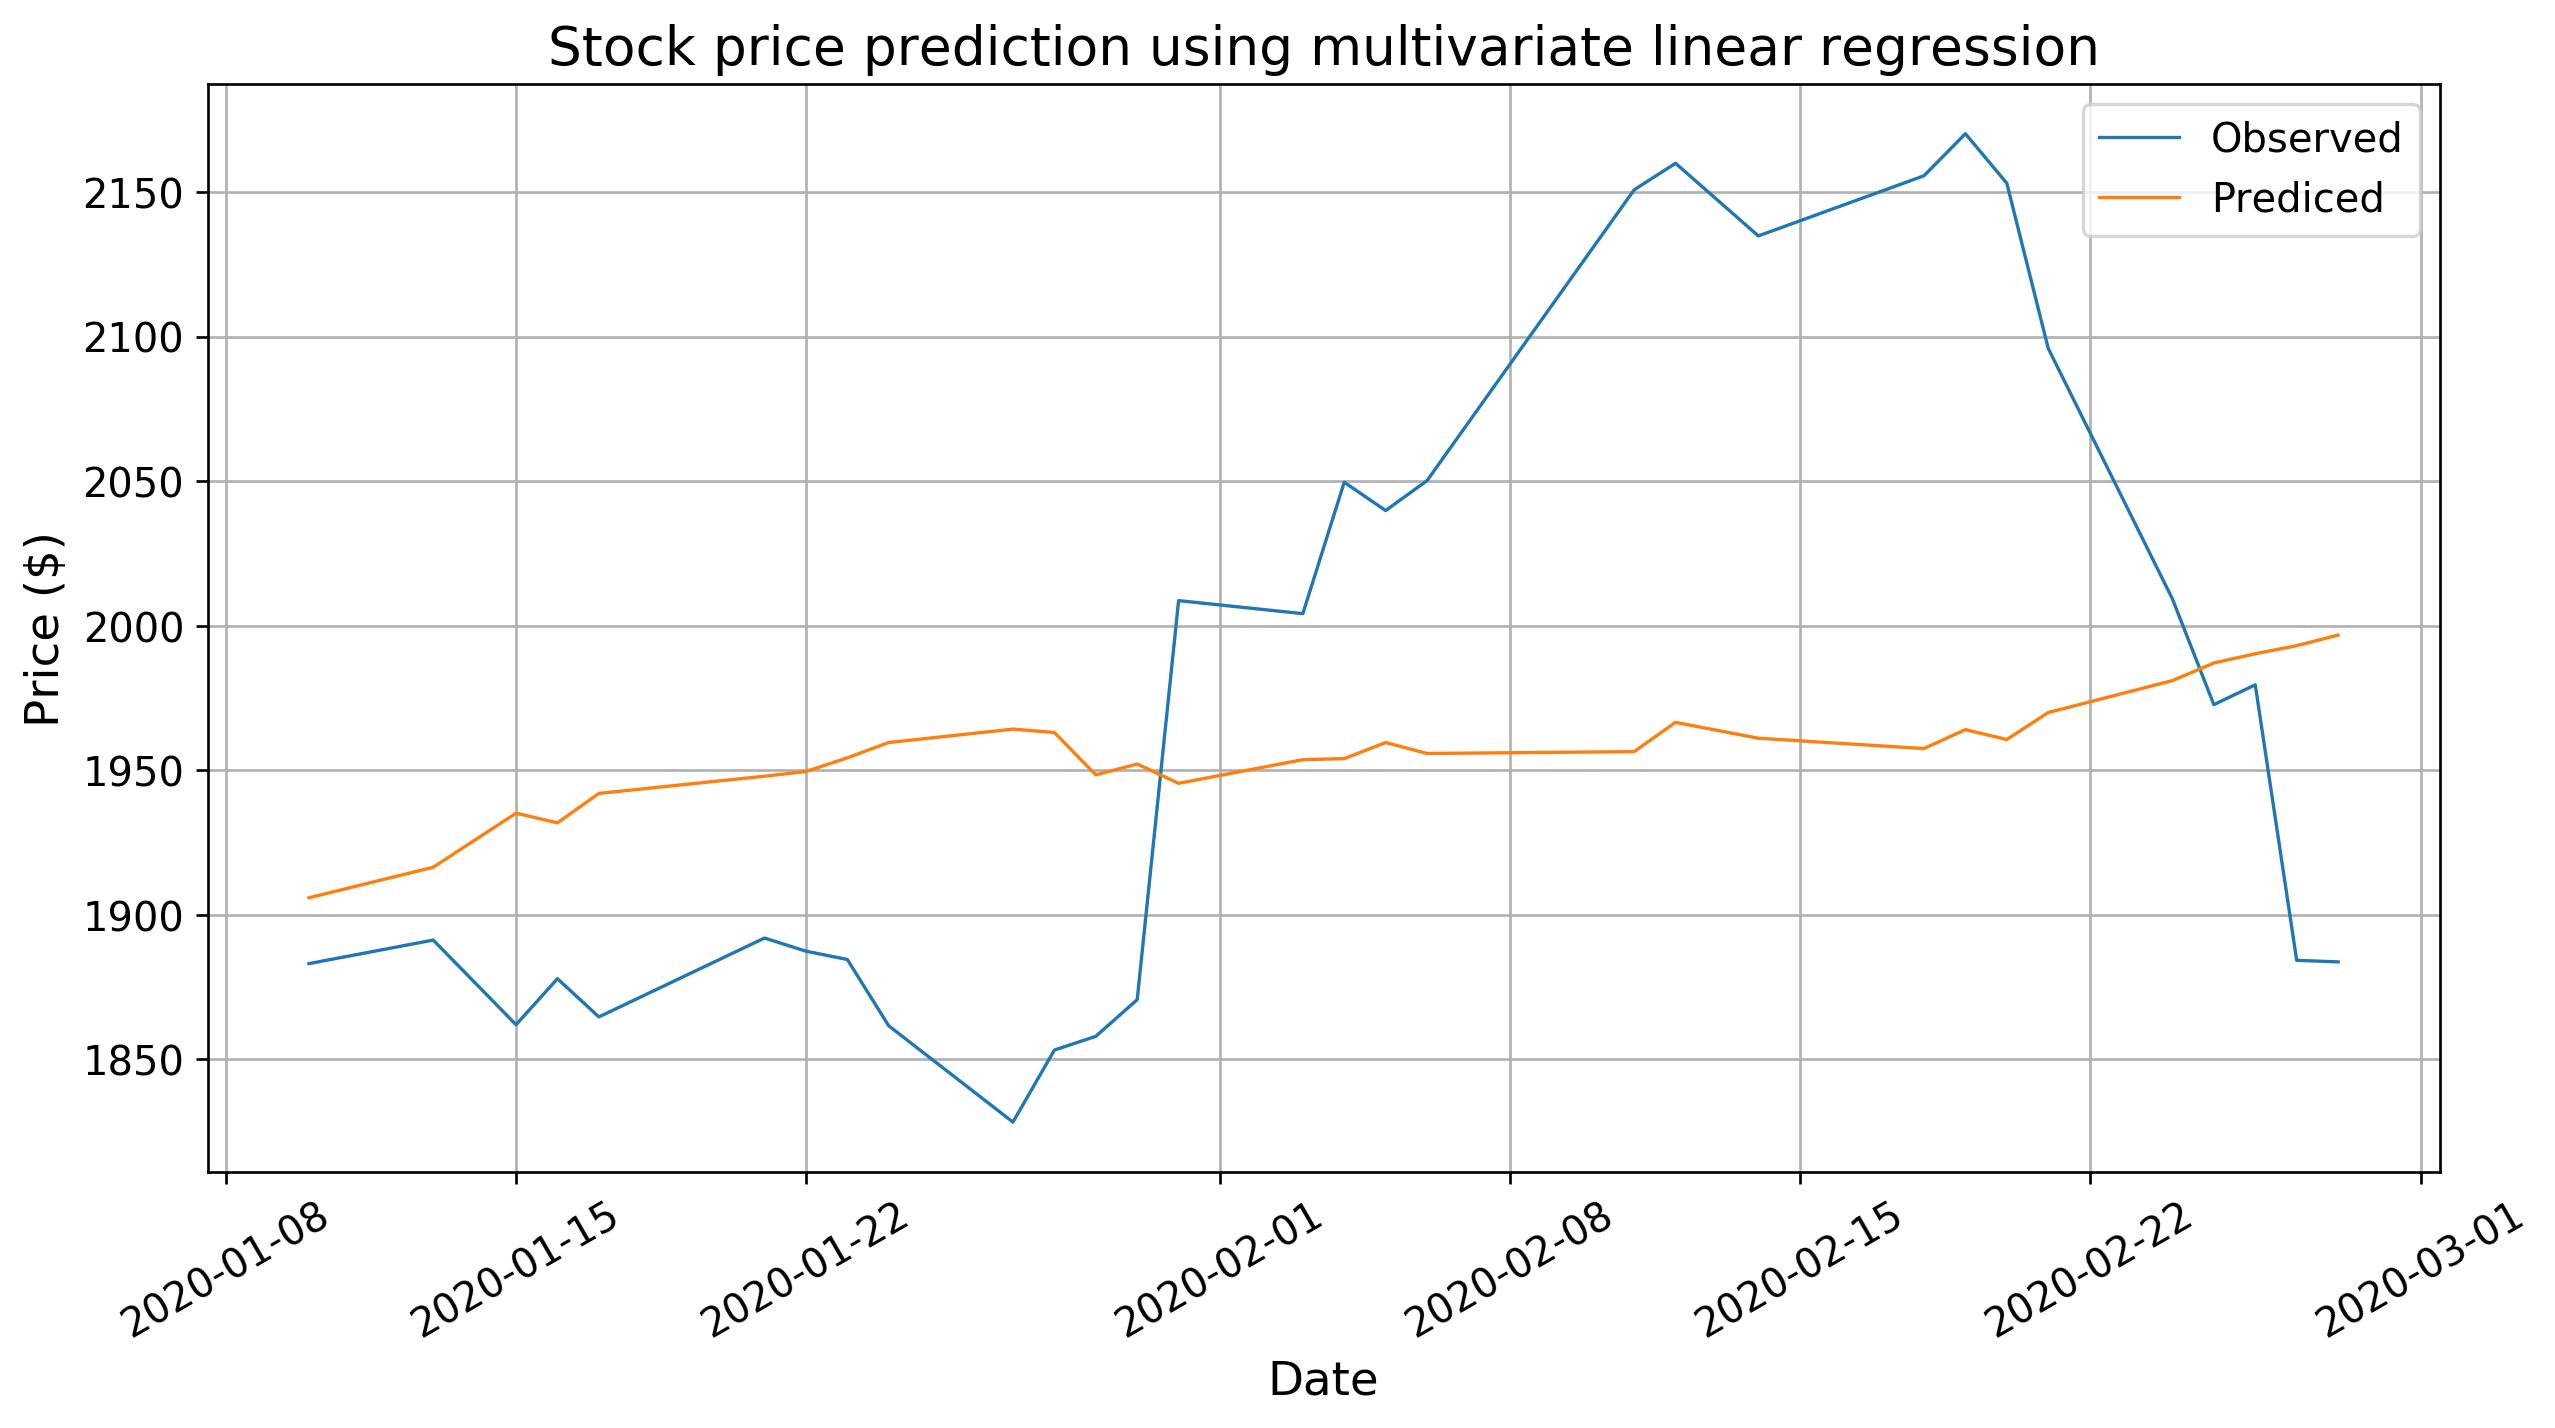

In [17]:
plt.plot(y_test.index, y_test.values, label = 'Observed')

plt.plot(y_test.index, y_pred_lm, label = 'Prediced')

plt.legend(loc = 'best')
plt.title('Stock price prediction using multivariate linear regression')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.xticks(rotation=30)

plt.show()

In [18]:
# RMSE

print(RMSE(observations=y_test, predictions=y_pred_lm))

112.39584705733299


# Multivariate Non-Linear (Polynomial) Regression of Degree > 1

In [19]:
# from sklearn.preprocessing import PolynomialFeatures

* **degree** is an integer (2 by default) that represents the degree of the polynomial regression function
* **interaction_only** is a Boolean (False by default) that decides whether to include only interaction features (True) or all features (False)
* **include_bias** is a Boolean (True by default) that decides whether to include the bias (intercept) column of ones (True) or not (False)

In [20]:
# degrees = range(2, 4)

# degree = []

# rmse = []

# for d in degrees:
    
#     degree.append(d)
    
#     x_train_trans = PolynomialFeatures(degree=d, include_bias=False).fit_transform(x_train)

#     x_test_trans = PolynomialFeatures(degree=d, include_bias=False).fit_transform(x_test)
    
#     # Create a model and fit it

#     poly = LinearRegression().fit(x_train_trans, y_train)
    
#     y_pred_poly = poly.predict(x_test_trans)
    
#     rmse.append(RMSE(observations=y_test, predictions=y_pred_poly))
    
#     print('Running Multivariate Polynomial Regression of Degree:', d)
    
# # Create a data frame with the results

# poly_res = pd.DataFrame(list(zip(degree, rmse)), columns=['degree', 'rmse'])

# # Re-run with the best d (the one that produces the minimum RMSE)

# best_d = poly_res.iloc[poly_res.rmse.idxmin(), 0]

# x_train_trans = PolynomialFeatures(degree=best_d, include_bias=False).fit_transform(x_train)

# x_test_trans = PolynomialFeatures(degree=best_d, include_bias=False).fit_transform(x_test)
    
# poly = LinearRegression().fit(x_train_trans, y_train)
    
# y_pred_poly = poly.predict(x_test_trans)

In [21]:
# plt.plot(y_test.index, y_test.values, label = 'Observed')

# plt.plot(y_test.index, y_pred_poly, label = 'Prediced')

# plt.legend(loc = 'best')
# plt.title('Stock price prediction using multivariate non-linear regression of degree ' + str(best_d))
# plt.xlabel('Date')
# plt.ylabel('Price ($)')
# plt.xticks(rotation=30)

# plt.show()

# # RMSE

# print('\n\n', RMSE(observations=y_test, predictions=y_pred_poly))

# Predict the future

In [22]:
# # Stock price prediction using multivariate non-linear regression

# f_test = data.drop(labels = 'adjusted_close', axis = 1).iloc[0:pred_period, :].sort_index()

# f_test_trans = PolynomialFeatures(degree=best_d, include_bias=False).fit_transform(f_test)

# f_pred = poly.predict(f_test_trans)

# f_dates = [f_test.index[-1] + datetime.timedelta(days=1) + datetime.timedelta(days=x) for x in range(len(f_pred))]

# # Store forecasts

# forecast = pd.DataFrame(list(zip(f_dates, f_pred)), columns=['date', 'price'])

In [23]:
# Stock price prediction using multivariate linear regression

f_test = data.drop(labels = 'adjusted_close', axis = 1).iloc[0:pred_period, :].sort_index()

f_pred_lm = lm.predict(f_test)

f_dates = [f_test.index[-1] + datetime.timedelta(days=1) + datetime.timedelta(days=x) for x in range(len(f_pred_lm))]

forecast_lm = pd.DataFrame(list(zip(f_dates, f_pred_lm)), columns=['date', 'price'])

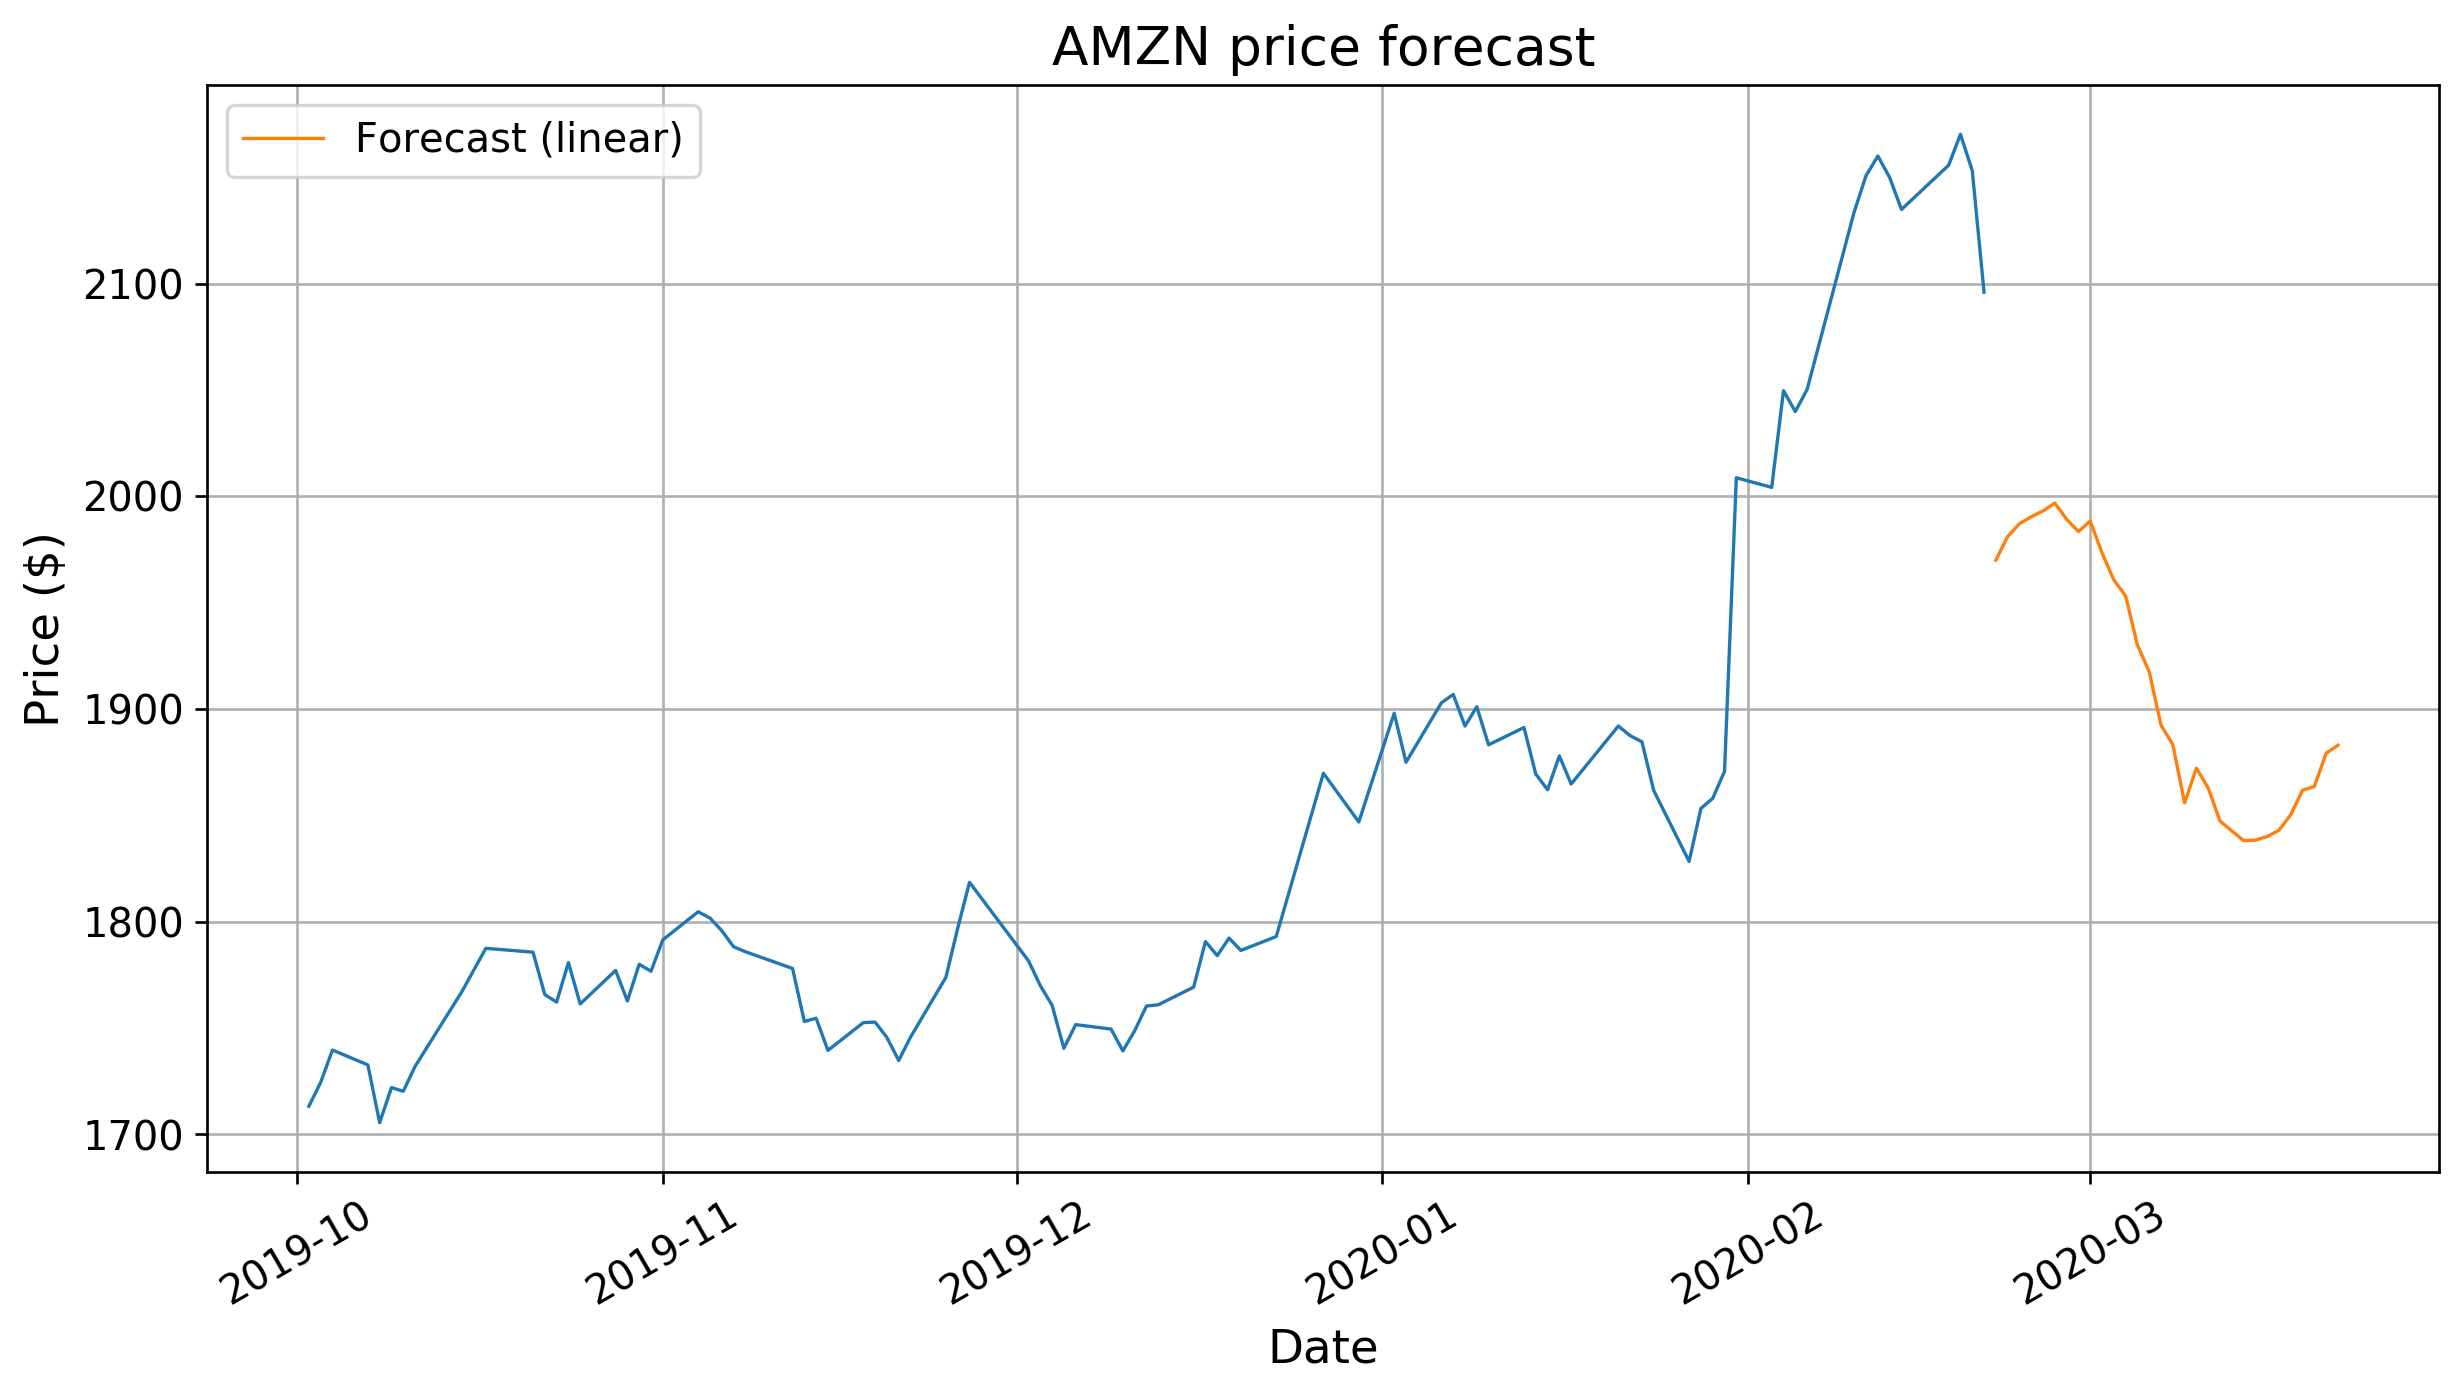

In [24]:
plt.plot(data.iloc[:90, :].index, data.iloc[:90, :]['adjusted_close'])

# plt.plot(forecast.date, forecast.price, label = 'Forecast (non-linear)')

plt.plot(forecast_lm.date, forecast_lm.price, label = 'Forecast (linear)')

plt.legend(loc = 'best')
plt.title(stock + ' price forecast')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.xticks(rotation=30)

plt.show()

In [25]:
new = forecast_lm.iloc[-1, 1] # predicted price after a month

current = stock_data.loc[:, 'adjusted_close'][0] # latest price

(new - current) * 100 / current # percentage change

-0.04330409745133595

In [26]:
forecast_lm.columns = [ 'date', forecast_lm.columns[1] + '_' + str(end_date).replace('-', '_') ]

In [27]:
# if 'predictions.csv' in os.listdir(os.getcwd()):
    
#     preds = pd.read_csv('predictions.csv', index_col=0)
    
#     if len(preds) != len(forecast_lm):
        
#         new_row_index = datetime.datetime.strptime(preds.index[-1], '%Y-%m-%d').date() + datetime.timedelta(days=1)
        
#         tmp = pd.DataFrame(data=[0], columns=[preds.columns[-1]], index=[new_row_index])
        
#         preds = preds.append(tmp)
        
        
        
# else:
    
#     forecast_lm.to_csv(os.getcwd() + '/predictions.csv', sep=',', index=False)